# Tutorial VI - Unit Commitment Problem

Energy System Optimization with Julia

# 1. Modelling the Unit Commitment Problem

Implement the Unit Commitment problem from the lecture in Julia. Before
we start, let’s load the necessary packages and data.

In [1]:
using JuMP, HiGHS
using CSV
using DataFrames
using Plots
using Dates

Now, let’s load the data. The generator data includes additional
parameters for UC, and the scenario data now includes timestamps and
hourly values.

In [2]:
# Get the directory of the current file
file_directory = "$(@__DIR__)/data"

# Load the data of the thermal generators
generators = CSV.read("$file_directory/generator.csv", DataFrame)
println("Number of generators: $(nrow(generators))")
println("First 5 rows of available generators:")
println(generators[1:5, :])

Number of generators: 6
First 5 rows of available generators:
5×10 DataFrame
 Row │ name     min_power  max_power  variable_cost  fix_cost  min_up_time  min_down_time  ramp_up  ramp_down  startup_cost 
     │ String3  Int64      Int64      Int64          Int64     Int64        Int64          Int64    Int64      Int64        
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ G1             100        500             50      1000            4              2      100        100          5000
   2 │ G2              50        350             60      1200            2              1       50         50          2000
   3 │ G3              40        250             55      1300            1              1       20         20          1000
   4 │ G4              30        200             70      1500            4              2      100        100          5000
   5 │ G5              30        200             60 

In [3]:
# Load the data of the wind turbines
windTurbines = CSV.read("$file_directory/windTurbine.csv", DataFrame)
println("Number of wind turbines: $(nrow(windTurbines))")
println("Variable cost per wind turbine:")
println(windTurbines)

Number of wind turbines: 1
Variable cost per wind turbine:
1×2 DataFrame
 Row │ name     variable_cost 
     │ String3  Int64         
─────┼────────────────────────
   1 │ T1                  50


In [4]:
# Load the scenario data about the demand and wind forecast
scenarios = CSV.read("$file_directory/scenario.csv", DataFrame)
println("First 5 rows of scenarios:")
println(scenarios[1:5, :])

First 5 rows of scenarios:
5×4 DataFrame
 Row │ scenario  datetime             demand_forecast  wind_forecast 
     │ String3   String31             Int64            Int64         
─────┼───────────────────────────────────────────────────────────────
   1 │ S1        2024-01-01 00:00:00              800            200
   2 │ S1        2024-01-01 01:00:00              750            180
   3 │ S1        2024-01-01 02:00:00              700            150
   4 │ S1        2024-01-01 03:00:00              650            120
   5 │ S1        2024-01-01 04:00:00              600            100


Next, prepare the data structures for the model. We’ll create
NamedTuples for generators, wind turbines, and scenarios:

In [7]:
# This function creates the Named Tuple ThermalGenerator
# It stores all parameters needed for a thermal generator in the UC problem:
# - min/max: minimum and maximum power output
# - fixed_cost: cost per hour when the generator is running
# - variable_cost: cost per MWh of power produced
# - min_up_time: minimum number of hours the generator must stay on once started
# - min_down_time: minimum number of hours the generator must stay off once shut down
# - ramp_up/down: maximum power change between consecutive hours
# - startup_cost: one-time cost when starting the generator
function ThermalGenerator(
    min::Int64,
    max::Int64,
    fixed_cost::Int64,
    variable_cost::Int64,
    min_up_time::Int64,
    min_down_time::Int64,
    ramp_up::Int64,
    ramp_down::Int64,
    startup_cost::Int64
)
    return (
        min = min,
        max = max,
        fixed_cost = fixed_cost,
        variable_cost = variable_cost,
        min_up_time = min_up_time,
        min_down_time = min_down_time,
        ramp_up = ramp_up,
        ramp_down = ramp_down,
        startup_cost = startup_cost
    )
end

# Create dictionaries for the data
# Each generator's parameters are stored in a NamedTuple for easy access
dictThermalGenerators = Dict(row.name => ThermalGenerator(
    row.min_power, row.max_power, row.fix_cost, row.variable_cost,
    row.min_up_time, row.min_down_time, row.ramp_up, row.ramp_down,
    row.startup_cost
) for row in eachrow(generators))

# Create dictionary for wind turbines
# Wind turbines only have variable costs as they don't have startup/shutdown constraints
dictWindTurbines = Dict(row.name => (variable_cost = row.variable_cost,) for row in eachrow(windTurbines))

# Create dictionary for scenarios
# Each scenario contains time series data for demand and wind forecasts
date_format = dateformat"yyyy-mm-dd HH:MM:SS"
dictScenarios = Dict()
for scenario in unique(scenarios.scenario)
    scenario_data = scenarios[scenarios.scenario .== scenario, :]
    dictScenarios[scenario] = (
        datetime = DateTime.(scenario_data.datetime, date_format),
        demand_forecast = scenario_data.demand_forecast,
        wind_forecast = scenario_data.wind_forecast
    )
end

# 2. Implementing Startup Variables and Costs

In the Unit Commitment problem, we need to track when generators are
started up, as this incurs additional costs. This aspect was not covered
in detail in the lecture, so let’s implement it here.

## Task: Implement Startup Variables and Costs

1.  We need to add a binary variable `v_g[g,t]` that equals 1 if
    generator g is started up at time t, and 0 otherwise.
2.  The startup cost should be included in the objective function.
3.  We need to link the startup variable to the generator status
    variable `u_g[g,t]`.

The relationship between `v_g` and `u_g` is: If a generator is off at
t-1 (`u_g[g,t-1] = 0`) and on at t (`u_g[g,t] = 1`), then it must have
been started up (`v_g[g,t] = 1`).

How can this be expressed?

In [0]:
## YOUR ANSWER HERE
`v_g[g,t] >= u_g[g,t] - u_g[g,t-1]`


Now, let’s implement the Unit Commitment model in a function:

In [8]:
function solve_unit_commitment(dictThermalGenerators::Dict, dictWindTurbines::Dict, scenario)
    # Create the model
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    
    # Define the time periods and sets
    T = 1:length(scenario.datetime)  # Time periods (hours)
    G = keys(dictThermalGenerators)  # Set of thermal generators
    W = keys(dictWindTurbines)       # Set of wind turbines
    
    # Define variables
    @variable(model, p_g[g in G, t in T] >= 0)  # Power output of generators [MW]
    @variable(model, p_w[w in W, t in T] >= 0)  # Power output of wind turbines [MW]
    @variable(model, u_g[g in G, t in T], Bin)  # Binary variable for generator status (1=on, 0=off)
    @variable(model, v_g[g in G, t in T], Bin)  # Binary variable for startup (1=startup, 0=no startup)
    
    # Objective function: Minimize total costs
    # Costs include:
    # 1. Variable costs for power production
    # 2. Fixed costs when generator is running
    # 3. Startup costs when generator is started
    # 4. Variable costs for wind power
    @objective(model, Min, sum(
        dictThermalGenerators[g].variable_cost * p_g[g,t] +  # Variable cost of production
        dictThermalGenerators[g].fixed_cost * u_g[g,t] +     # Fixed cost when running
        dictThermalGenerators[g].startup_cost * v_g[g,t]     # Startup cost
        for g in G, t in T
    ) + sum(
        dictWindTurbines[w].variable_cost * p_w[w,t]         # Wind power variable cost
        for w in W, t in T
    ))
    
    # Power balance constraint: Total generation must equal demand
    @constraint(model, power_balance[t in T],
        sum(p_g[g,t] for g in G) + sum(p_w[w,t] for w in W) == scenario.demand_forecast[t]
    )
    
    # Generator limits: Power output must be within min/max when running
    @constraint(model, gen_min[g in G, t in T],
        p_g[g,t] >= dictThermalGenerators[g].min * u_g[g,t]  # Min power when running
    )
    @constraint(model, gen_max[g in G, t in T],
        p_g[g,t] <= dictThermalGenerators[g].max * u_g[g,t]  # Max power when running
    )
    
    # Wind limits: Wind power cannot exceed forecast
    @constraint(model, wind_max[w in W, t in T],
        p_w[w,t] <= scenario.wind_forecast[t]
    )
    
    # Minimum up time: Generator must stay on for minimum duration after startup
    @constraint(model, min_up[g in G, t in T],
        sum(u_g[g,τ] for τ in max(1, t-dictThermalGenerators[g].min_up_time+1):t) >= 
        dictThermalGenerators[g].min_up_time * v_g[g,t]
    )
    
    # Minimum down time: Generator must stay off for minimum duration after shutdown
    @constraint(model, min_down[g in G, t in T],
        sum(1 - u_g[g,τ] for τ in max(1, t-dictThermalGenerators[g].min_down_time+1):t) >= 
        dictThermalGenerators[g].min_down_time * (1 - u_g[g,t])
    )
    
    # Ramp rate limits: Power change between consecutive hours is limited
    @constraint(model, ramp_up[g in G, t in 2:length(T)],
        p_g[g,t] - p_g[g,t-1] <= dictThermalGenerators[g].ramp_up    # Max ramp up
    )
    @constraint(model, ramp_down[g in G, t in 2:length(T)],
        p_g[g,t-1] - p_g[g,t] <= dictThermalGenerators[g].ramp_down  # Max ramp down
    )
    
    # Startup variable definition: v_g[g,t] = 1 if generator g is started at time t
    @constraint(model, startup[g in G, t in 2:length(T)],
        v_g[g,t] >= u_g[g,t] - u_g[g,t-1]  # v_g = 1 if u_g changes from 0 to 1
    )
    
    # Solve the model
    optimize!(model)
    
    # Return results
    return (
        p_g = value.(p_g),      # Generator power output
        p_w = value.(p_w),      # Wind power output
        u_g = value.(u_g),      # Generator status
        v_g = value.(v_g),      # Startup events
        total_cost = objective_value(model)
    )
end

solve_unit_commitment (generic function with 1 method)

Now, let’s solve the model for all scenarios and store the results:

In [9]:
# Create a dataframe to store results
results_df = DataFrame(
    scenario = String[],        # Scenario identifier
    datetime = DateTime[],      # Timestamp
    total_cost = Float64[],     # Total system cost
    wind_curtailment = Float64[], # Curtailed wind power
    thermal_generation = Float64[], # Total thermal generation
    wind_generation = Float64[]    # Total wind generation
)

# Loop over scenarios
for (scenario_name, scenario_data) in dictScenarios
    solution = solve_unit_commitment(dictThermalGenerators, dictWindTurbines, scenario_data)
    
    # Store results for each time period
    for t in 1:length(scenario_data.datetime)
        push!(results_df, (
            scenario_name,
            scenario_data.datetime[t],
            solution.total_cost,
            sum(scenario_data.wind_forecast[t] - solution.p_w[w,t] for w in keys(dictWindTurbines)),
            sum(solution.p_g[g,t] for g in keys(dictThermalGenerators)),
            sum(solution.p_w[w,t] for w in keys(dictWindTurbines))
        ))
    end
end

Finally, let’s plot the results:

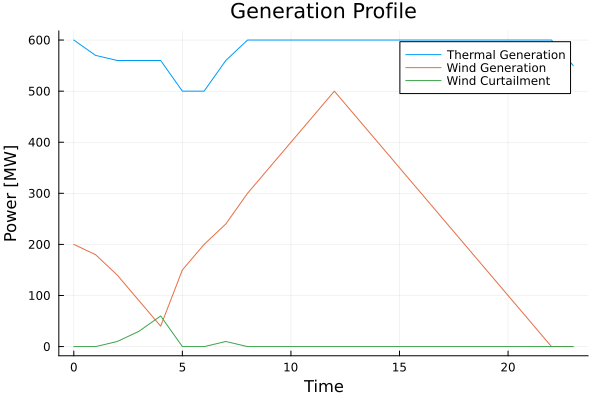

In [12]:
# Format datetime to show only hours
hours = hour.(results_df.datetime)

# Plot generation over time
plot(hours, results_df.thermal_generation, 
    label="Thermal Generation", xlabel="Time", ylabel="Power [MW]")
plot!(hours, results_df.wind_generation, 
    label="Wind Generation")
plot!(hours, results_df.wind_curtailment, 
    label="Wind Curtailment")
title!("Generation Profile")


------------------------------------------------------------------------

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.

Later, you will find the solutions to these exercises online in the
associated GitHub repository, but we will also quickly go over them in
next week’s tutorial. To access the solutions, click on the Github
button on the lower right and search for the folder with today’s lecture
and tutorial. Alternatively, you can ask ChatGPT or Claude to explain
them to you. But please remember, the goal is not just to complete the
exercises, but to understand the concepts and improve your programming
abilities.